# Предсказание стоимости автомобиля

Для сервиса по продаже автомобилей необходимо построить модель для определения рыночной стоимости автомобиля на основе исторических данных: технические характеристики, комплектации и цены автомобилей.

Требования к модели:
- качество предсказания;
- скорость предсказания;
- время обучения.

## План работы

### Шаг 1. Загрузка и подготовка данных
- [1. Импорт библиотек, изучение данных](#section1)
- [2. Обработка выбросов](#section2)
- [3. Обработка пропусков](#section9)

### Шаг 2. Обучение моделей
- [1. Подготовка выборок](#section3)
- [2. Обучение LGBMRegressor](#section4)
- [3. Обучение CatBoostRegressor](#section5)
- [4. Другой алгоритм обработки пропусков](#section6)

### Шаг 3. Анализ результатов
- [1. Анализ результатов работы различных моделей](#section7)

### Шаг 1. Загрузка и подготовка данных

<a id='section1'></a>

#### 1. Импорт библиотек, загрузка и изучение данных

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

from  lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time

Далее прочитаем файл с данными и изучим общую информацию.

In [2]:
# Путь к файлу на локальном компьютере
path = 'datasets/autos.csv'

df = pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType, NotRepaired. Столбцы DateCrawled, DateCreated и LastSeen содержат даты, но имеют неверный тип данных.

Взглянем на распределение числовых данных.

In [3]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Столбец Price содержит нулевые значения. Столбцы RegistrationYear и Power имеет нереальные значения: слишком маленькие и слишком большие. Столбец RegistrationMonth имеет нулевые значения. Все значения в столбце NumberOfPictures - нулевые.

<a id='section2'></a>

#### 2. Обработка выбросов

Распределение числовых данных позволило определить столбцы, в которых есть выбросы. В столбцах с категориальными данными есть пропуски. Сначала избавимся от выбросов, но прежде более подробно изучим данные в них.

Столбец RegistrationMonth не имеет значения, так как маловероятно, что он может как-то повлиять на цену автомобиля. Поэтому изучим данные в столбцах Price, RegistrationYear, Power и Kilometer

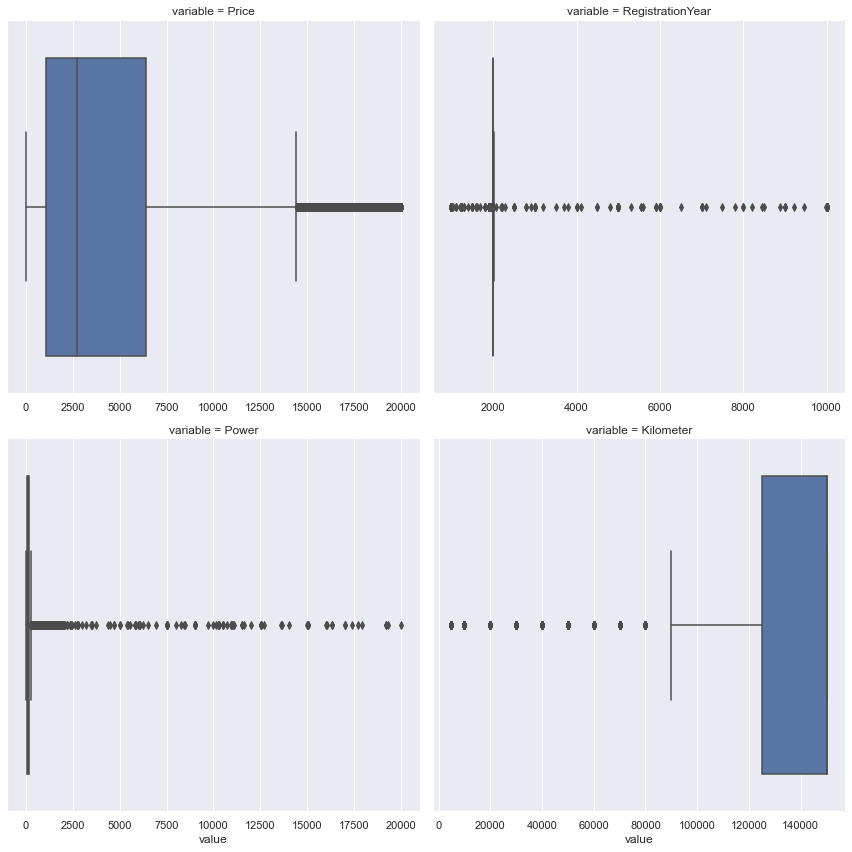

In [4]:
sns.set()

# Выделим признаки для изучения
numb_col = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def facet_boxplot(df, columns):
    # Сформируем FacetGrid
    g = sns.FacetGrid(pd.melt(df[columns]), col='variable', col_wrap=2, height=6, sharex=False)
    # Разместим на нем боксплоты
    g.map(sns.boxplot, 'value', order=any)
    plt.show()

facet_boxplot(df, numb_col)

Столбец Price содержит нулевые значения, а значения от 15000 до 20000 евро сложно назвать выбросами. Столбец Power содержит довольно много неадекватных значений. Есть как мощности меньше 63 л.с. (мощность Daewoo Matiz), так и больше 1500 л.с.(Bugatti Chiron). Значения в столбце Kilometer адекватные. По графику RegistrationYear очень сложно судить, с какого момента начинаются выбросы, но очевидно, что значение не может быть больше 2020 (текущий год) и меньше 1885 (появление первого автомобиля). Получим срез датафрейма с учетом изученной информации и посмотрим на распределение. 

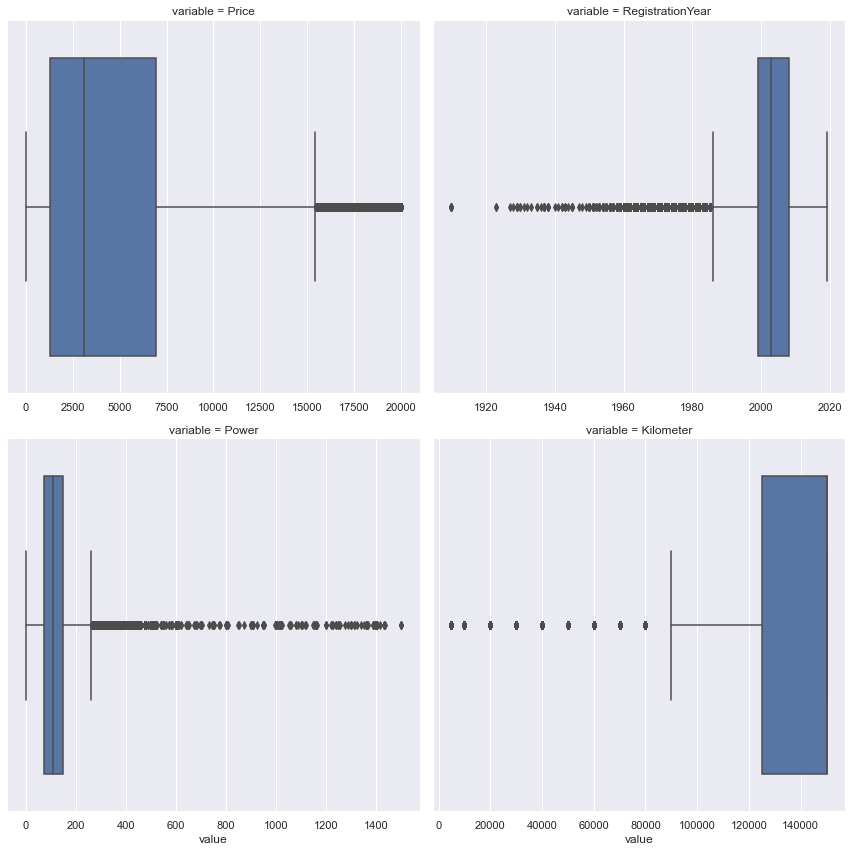

In [5]:
df_clean = df[(df['Price'] > 0) &
              (df['RegistrationYear'] >= 1885) &
              (df['RegistrationYear'] <= 2020) &
              (df['Power'] > 0) &
              (df['Power'] <= 1500)
             ]
facet_boxplot(df_clean, numb_col)

Теперь видно, что RegistrationYear можно ограничить снизу значением 1980.

In [6]:
df_clean = df_clean[df_clean['RegistrationYear'] >= 1980]

# Оценим потерю данных
len(df_clean) / len(df)

0.8601232049078785

Потеряли 14% данных, но теперь можем быть уверены, что выбросы не повлияют на качество модели.

<a id='section9'></a>

#### 3. Обработка пропусков

Теперь обработаем пропуски. В данной работе в дальнейшем будем использовать модели LGBMRegressor и CatBoostRegressor для прогнозирования целевого признака. Первая модель умеет сама обрабатывать пропуски, вторая - не умеет. Поэтому попробуем два варианта работы с пропусками, а затем сравним качество полученных моделей:
- Обработам пропуски на основе наиболее часто встречаемых значений для характерных моделей
- Дадим модели LGBMRegressor самостоятельно разобраться с пропусками, а для модели CatBoostRegressor заполним пропуски характерными значениями.

Для обработки пропусков реализуем функции. Для обучения первых моделей обработаем пропуски первым способом, который заключается в следующем:

Пропуски в столбце VehicleType можно обработать на основе данных о марке и модели, как и пропуски в столбцах Gearbox и FuelType: найдём максимально похожие модели автомобилей и возьмем значения с них. Определить модель автомобиля на основе других данных невозможно, так как у каждого производителя могут быть похожие по параметрами автомобили, но являющиеся разными моделями, поэтому пропуски в столбце Model просто удалим. Пропуски в столбце NotRepaired заменим на основе предположения, что если данных о ремонте не указано, значит автомобиль скорее всего не ремонтировался.

In [7]:
def na_processing(df_init, algoritm_num=1, model_num=1):
    '''
    Функция обработки пропусков в датафрейме
    df_init - исходный датафрейм
    algoritm_num - номер алгоритма:
        1 - обработка пропусков на основе словаря,
        2 - для LGBM пропуски игнорировать, для CB пропуски заполнить характрным значением
    model_num - номер используемой модели:
        1 - LGBM
        2 - CB
    Функция возвращает обработанный датафрейм
    '''
    # Будем работать с копией датафрейма, что бы случайно не удалить данные
    df = df_init.copy()
    if algoritm_num == 1:        
        # Удалим строки, в которых отсутствует название модели
        df.dropna(subset=['Model'], inplace=True)
        # Заполним отсутствующие значения в столбце NotRepaired значением 'no'
        df['NotRepaired'].fillna('no', inplace=True)
        
        # Теперь создадим словарь, в который для каждой модели поставим в соответствие
        # тип кузова, тип КПП, тип топлива на основе наиболее часто встречаемых значений

        # Сначала сгруппируем данные по указанным столбцам и посчитаем суммарное количество моделей
        df_agg = df.groupby(['Model', 'VehicleType', 'Gearbox', 'FuelType']).agg('count')
        # Для каждой модели оставим только наиболее часто встречаемые сочетания
        df_agg_best = df_agg['Price'].groupby(level=0, group_keys=False).nlargest(1).index.values
        # Преобразуем полученный двумерный массив в словарь
        df_agg_dict = dict((x[0], (x[1], x[2], x[3])) for x in df_agg_best)
        
        # Применим описанную функцию для заполнения пропусков
        df[['VehicleType', 'Gearbox', 'FuelType']] = df.apply(lambda x: pd.Series(filler_na(x, df_agg_dict)), axis=1)

        # Оценим потерю данных после обработки пропусков данным методом
        print('Потеря данных по первому сценарию: {:.3%}'.format(1 - len(df)/len(df_init)))
    if algoritm_num == 2:
        if model_num == 2:
            df.fillna(-1, inplace=True)
        else:
            return df
    return df
        
# Опишем функцию для заполнения пропусков на основе словаря
def filler_na(row, df_dict):
    '''
    Данная функция заполняет отсутствующие значения в столбцах
    Model, VehicleType, Gearbox и FuelType на основе словаря построчно
    row - строка датафрейма
    df_dict - словарь для заполнения пропусков
    Функция возвращает значения в соответствующих столбцах после обработки
    '''
    # Сначала запишем значения соответствующих столбцов в переменные
    Model = row['Model']
    VehicleType = row['VehicleType']
    Gearbox = row['Gearbox']
    FuelType = row['FuelType']
    # Если значение отсутствует - ищем соответствующее значение в словаре
    if pd.isna(VehicleType):
        VehicleType =  df_dict.get(Model)[0]
    if pd.isna(Gearbox):
        Gearbox =  df_dict.get(Model)[1]
    if pd.isna(FuelType):
        FuelType =  df_dict.get(Model)[2]
    # Возвращаем полученные значения
    return VehicleType, Gearbox, FuelType

Теперь опишем функцию для обработки датафрейма. Приведем тип данных в столбцах с датами к нужному виду, данные в столбце NotRepaired заменим на числа. Также создадим новые признаки, показывающие возраст автомобиля и время, за которое автомобиль купили. После чего удалим все лишние столбцы.

In [8]:
def df_preprocessing(df):
    '''
    Функция выполняет обработку датафрейма для дальнейшего обучения модели:
        - Приводит определенные столбцы к datetime формату
        - Обрабатывает значения в столбце NotRepaired
        - Добавляет новые признаки
        - Удаляет лишние признаки
    Функция возвращает обработанный датафрейм
    
    '''
    # Приведем столбцы с датами в нужный формат
    df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y%m%d %H:%M:%S')
    df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y%m%d %H:%M:%S')
    df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y%m%d %H:%M:%S')
    
    # Обработаем столбец NotRepaired
    df['NotRepaired'].replace('yes', 1, inplace=True)
    df['NotRepaired'].replace('no', 0, inplace=True)
    
    # Создадим новые признаки
    df['car_age'] = (df['DateCreated'].dt.year - df['RegistrationYear'])
    df['duration'] = (df['LastSeen'] - df['DateCreated']).dt.days
    
    # Удалим лишние столбцы
    df.drop(['DateCrawled',
             'RegistrationYear',
             'RegistrationMonth',
             'DateCreated', 
             'NumberOfPictures',
             'PostalCode',
             'LastSeen'
            ], axis=1, inplace=True)
    return df

Опишем функцию по обработке признаков.

In [9]:
def features_preprocessing(df, random_state=0):
    '''
    Функция для разделения датафрейма на тренировочные и тестовые выборки,
    определения фолдов для кросс-валидации
    df - исходный датафрейм
    Функция возвращает тренировочные и тестовые выборки, фолды и список признаков,
    содержащих категориальные данные
    '''
    # Отделим признаки от целевого признака
    X = df.drop('Price', axis=1)
    y = df['Price']
    
    # Для LGBMRegressor необходимо категориальные признаки привести к типу category
    # Выделим категориальные признаки
    cat_columns = X.select_dtypes(include='object').columns.tolist()
    X[cat_columns] = X[cat_columns].astype('category')
        
    # Разделим выборку на тренировочкую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state, shuffle=True)
    
    # Получим фолды для выполнения кросс валидации
    kf = list(KFold(n_splits=10, shuffle=True, random_state=random_state) \
              .split(X_train, y_train))
    return X_train, X_test, y_train, y_test, kf, cat_columns

Теперь напишем функцию полной предобработки датафрейма для обучения конкретной модели.

In [10]:
def preprocessing(df, algoritm_num=1, model_num=1, random_state=0):
    '''
    Функция выполняет полную предобработку исходного датафрейма:
        - обрабатывает пропуски
        - обрабатывает признаки
        - делит данные на тренировочные и тестовые выборки
    df - исходный датафрейм
    algoritm_num - номер алгоритма:
        1 - обработка пропусков на основе словаря,
        2 - для LGBM пропуски игнорировать, для CB пропуски заполнить характрным значением
    model_num - номер используемой модели:
        1 - LGBM
        2 - CB
    Функция возвращает тренировочные и тестовые выборки, фолды и список признаков,
    содержащих категориальные данные
    '''
    df = na_processing(df, algoritm_num, model_num)
    df = df_preprocessing(df)
    X_train, X_test, y_train, y_test, kf, cat_columns = features_preprocessing(df, random_state)
    return X_train, X_test, y_train, y_test, kf, cat_columns

### Вывод



Данные были загружены и изучены. Затем были написаны функции для обработки пропусков, приведения типа данных в столбцах к нужному виду, создания новых признаков, удаления лишних столбцов и разделения датафрейма на тренировочную и тестовую выборки.

### Шаг 2. Обучение моделей

<a id='section3'></a>

#### 1. Подготовка выборок

Прежде, чем приступать к обучению моделей, необходимо выполнить функцию предобработки данных, создать метрику на основе MSE.

In [11]:
random_state = 321

# Разделим датафрейм на выборки
X_train, X_test, y_train, y_test, kf, cat_columns = preprocessing(df_clean, 1, 1, random_state)

# Создадим метрику на основе MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

Потеря данных по первому сценарию: 3.940%


Обработка пропусков по первому сценарию привела к потере 4% данных. Можно приступать к обучению моделей.

<a id='section4'></a>

#### 2. Обучение LGBMRegressor

Сначала попробуем обучить LGBMRegressor со стандартными значениями гиперпараметров.

In [12]:
# Опишем функции для вывода результатов
def rmse_calc(model, X_train, X_test, y_train, y_test, kf, catboost=False):
    '''
    Функция выводит значение RMSE на тренировочных и тестовых данных
    model - обученная модель
    X_train - признаки тренировочной выборки
    X_test - признаки тестовой выборки
    y_train - целевой признак тренировочной выборки
    y_test - целевой признак тестовой выборки
    kf - фолды для выполнения кросс-валидации
    catboost - является ли model CB
    Результат расчета метрик добавляется в соответствующий лист
    '''
    # Получим предсказания
    y_pred = model.predict(X_test)

    # Рассчитаем RMSE
    if catboost:
        score_train = list(list(model.best_score_.values())[0].values())[0]
    else:
        score_train = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring=mse_scorer, n_jobs=-1)*(-1))**0.5
    score_test = mean_squared_error(y_test, y_pred)**0.5
    print('RMSE на тренировочной выборке = {}, на тестовой = {}'.format(score_train, score_test))
    rmse_train.append(score_train)
    rmse_test.append(score_test)

def fit_time(model, X, y):
    '''
    Функция засекает время обучения модели, а также выполняет само обучение
    model - обучаемая модель
    X - признаки выборки
    y - целевой признак
    Время обучения добавляется в лист
    '''
    start = time.time()
    model.fit(X, y)
    end = time.time()
    ex_time = end - start
    minutes = ex_time // 60
    seconds = ex_time % 60
    print('Время обучения модели: {:.0f} минут, {:.3f} секунд'.format(minutes, seconds))
    times.append(ex_time)

# Создадим пустые списки для записи времени обучения моделей и метрик
times = []
rmse_train = []
rmse_test = []

In [13]:
# Выберем регрессор
model = LGBMRegressor()
# Обучим модель
fit_time(model, X_train, y_train)
# Получим метрику
rmse_calc(model, X_train, X_test, y_train, y_test, kf)

Время обучения модели: 0 минут, 0.703 секунд
RMSE на тренировочной выборке = 1555.1476113518422, на тестовой = 1561.272792661019


Модель обучается очень быстро, менее чем за секунду, RMSE на тестовой выборке 1561. Попробуем подобрать гиперпараметры с помощью GridSeachCV

In [14]:
# Выберем регрессор
model = LGBMRegressor(n_estimators=700)

# Зададим варианты изменения гиперпараметров
params = {'num_leaves': range(6, 31, 5),
          'learning_rate': [0.005, 0.01, 0.05, 0.2]
         }

# Опишем GridSearchCV
grid = GridSearchCV(model,
                    params,
                    scoring=mse_scorer,
                    n_jobs=-1,
                    cv=kf
                   )

In [15]:
%%time
# Обучим модель GridSearchCV
grid.fit(X_train, y_train)

Wall time: 7min 55s


GridSearchCV(cv=[(array([     0,      1,      2, ..., 219590, 219591, 219592]),
                  array([     3,     12,     20, ..., 219573, 219581, 219586])),
                 (array([     0,      1,      2, ..., 219590, 219591, 219592]),
                  array([     4,     21,     46, ..., 219536, 219568, 219571])),
                 (array([     0,      2,      3, ..., 219590, 219591, 219592]),
                  array([     1,     15,     28, ..., 219561, 219575, 219584])),
                 (array([     0,      1,      3, ..., 219590, 219591, 219592]),
                  array([     2,      5,      9, ..., 219570, 219577, 219578]))...
                 (array([     0,      1,      2, ..., 219589, 219590, 219591]),
                  array([     6,      8,     48, ..., 219579, 219580, 219592])),
                 (array([     0,      1,      2, ..., 219590, 219591, 219592]),
                  array([     7,     24,     25, ..., 219521, 219567, 219574]))],
             estimator=LGBMRegr

In [16]:
# Выберем регрессор с лучшими гиперпараметрами
model_best = grid.best_estimator_

# Обучим лучший регрессор на тренировочных данных
fit_time(model_best, X_train, y_train)

# Выведем значения метрик
rmse_calc(model_best, X_train, X_test, y_train, y_test, kf)

Время обучения модели: 0 минут, 2.636 секунд
RMSE на тренировочной выборке = 1477.624702784316, на тестовой = 1477.6586220791028


Подбор гиперпараметров довольно длителен - 8 минут, но он позволил получить модель, которая обучается за 2 секунды, RMSE на тестовой выборке стал 1478.

<a id='section5'></a>

#### 3. Обучение CatBoostRegressor

По заявлениям разработчиков CatBoostRegressor "из коробки" показывает очень хорошие результаты, большие чем другие модели бустинга. Поэтому обучим модель CatBoostRegressor со стандартными значениями гиперпараметров. Датафрейм уже предобработан по первому алгоритму.

In [17]:
# Выберем регрессор
model = CatBoostRegressor(verbose=250, cat_features=cat_columns)

# Обучим модель
fit_time(model, X_train, y_train)

# Выведем значение метрик
rmse_calc(model, X_train, X_test, y_train, y_test, kf, True)

Learning rate set to 0.101908
0:	learn: 4282.6852551	total: 264ms	remaining: 4m 23s
250:	learn: 1584.0956094	total: 22.7s	remaining: 1m 7s
500:	learn: 1519.3447270	total: 45.6s	remaining: 45.4s
750:	learn: 1484.4754667	total: 1m 8s	remaining: 22.6s
999:	learn: 1460.5499911	total: 1m 30s	remaining: 0us
Время обучения модели: 1 минут, 32.079 секунд
RMSE на тренировочной выборке = 1460.5499910659128, на тестовой = 1531.2741330127103


На тренировочной выборке CatBoostRegressor действительно показал отличный RMSE, но на тестовой выборке RMSE оказался выше, что говорит о переобучении модели. Кроме того обучается модель значительно дольше, чем LGBM.

<a id='section6'></a>

#### 4. Другой алгоритм обработки пропусков

Теперь попробуем второй алгоритм работы с пропусками.

In [18]:
# Разделим датафрейм на выборки для модели LGBM
X_train, X_test, y_train, y_test, kf, cat_columns = preprocessing(df_clean, 2, 1, random_state)

Обучим LGBMRegressor с параметрами по умолчанию.

In [19]:
# Выберем регрессор
model = LGBMRegressor()
# Обучим модель
fit_time(model, X_train, y_train)
# Получим метрику
rmse_calc(model, X_train, X_test, y_train, y_test, kf)

Время обучения модели: 0 минут, 0.752 секунд
RMSE на тренировочной выборке = 1572.6543247617656, на тестовой = 1574.1820999599072


Теперь обучим LGBMRegressor с лучшими гиперпараметрами.

In [20]:
# Обучим лучший регрессор на тренировочных данных
fit_time(model_best, X_train, y_train)

# Выведем значения метрик
rmse_calc(model_best, X_train, X_test, y_train, y_test, kf)

Время обучения модели: 0 минут, 2.637 секунд
RMSE на тренировочной выборке = 1490.958308712495, на тестовой = 1487.8709007712534


Для обучения CB необходимо снова предобработать данные по второму алгоритму, так как для него есть отличия.

In [21]:
# Разделим датафрейм на выборки для модели LGBM
X_train, X_test, y_train, y_test, kf, cat_columns = preprocessing(df_clean, 2, 2, random_state)

# Выберем регрессор
model = CatBoostRegressor(verbose=250, cat_features=cat_columns)

# Обучим модель
fit_time(model, X_train, y_train)

# Получим значения метрик
rmse_calc(model, X_train, X_test, y_train, y_test, kf, True)

Learning rate set to 0.10264
0:	learn: 4261.1034205	total: 140ms	remaining: 2m 19s
250:	learn: 1590.7358968	total: 27s	remaining: 1m 20s
500:	learn: 1527.7212501	total: 52.3s	remaining: 52s
750:	learn: 1494.3571134	total: 1m 20s	remaining: 26.6s
999:	learn: 1471.8293803	total: 1m 47s	remaining: 0us
Время обучения модели: 1 минут, 48.852 секунд
RMSE на тренировочной выборке = 1471.82938028138, на тестовой = 1541.2252642715612


### Вывод

На данном шаге были обучены две разные модели с разными вариантами обработки пропусков. Анализ результатов будет произведен на следующем шаге.

### Шаг 3. Анализ результатов

<a id='section7'></a>

#### 1. Анализ результатов работы различных моделей

Сформируем сводную таблицы по всем расчетам и проанализируем результаты.

In [22]:
model_name = ['LGBM', 'LGBM', 'CB', 'LGBM', 'LGBM', 'CB']
model_param = ['init', 'best', 'init', 'init', 'best', 'init']
na_alg = [1, 1, 1, 2, 2, 2]
df_results = pd.DataFrame({'model': model_name,
                           'params': model_param,
                           'na_alg': na_alg,
                           'time':times,
                           'RMSE_train': rmse_train,
                           'RMSE_test': rmse_test                           
                          })
pd.pivot_table(df_results, index=['model', 'params'], columns='na_alg', values=['RMSE_train', 'RMSE_test', 'time'])

RMSE_test                RMSE_train                    time  \
na_alg                  1            2            1            2          1   
model params                                                                  
CB    init    1531.274133  1541.225264  1460.549991  1471.829380  92.078516   
LGBM  best    1477.658622  1487.870901  1477.624703  1490.958309   2.635996   
      init    1561.272793  1574.182100  1555.147611  1572.654325   0.702998   

                          
na_alg                 2  
model params              
CB    init    108.852332  
LGBM  best      2.636997  
      init      0.751999

Из полученной таблицы можно сделать следующие выводы:
- Модели LGBM обучаются очень быстро по сравнению с CB.
- На тренировочных данных модель CB "из коробки" обладает самымы высоким качеством по сравнению с моделями LGBM
- На тестовых данных модель CB также получает результат лучше, чем LGBM из коробки, но LGBM с оптимизированными гиперпараметрами выдает результат значительно лучше. Оптимизиация же параметров CB затруднительна, так как потребует огромного количества вычислительного времени.
- Модель CB более склонна к переобучению, чем модель LGBM
- Модель LGBM отлично справляется с пропусками, но ручная обработка пропусков более эффективна; ручная обработка пропусков для модели CB также оказывается эффективнее, чем заполнение всех пропусков характерным значением.

### Общий вывод

По всей проделанной работе можно сделать следующие выводы:
- Модели градиентного бустинга позволяют добиться отличных показателей метрики RMSE
- Модели градиентного бустинга не требуют ручной обработки пропусков, но с ручной обработкой качество оказывается выше
- Модель LGBM меньше склонна к переобучению, чем CB
- Модель CB "из коробки" действительно довольно эффективна, но оптимизированная модель LGBM выдает лучший результат
- Модель LGBM обучается значительно быстрее, чем модель CB
- Скорость предсказания всех моделей практически мгновенная

Таким образом модель CB с гиперпараметрами по умолчанию позволяет в первом приближении получить отличные показатели метрики RMSE. Для дальнейшего улучшения RMSE лучше использовать модель LGBM с оптимизированными гиперпараметрами.